In [1]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline




## Bernoulli Bandit

Несколько стратегий поиска для простейшей задачи - бандита Бернулли.

Бандит имеет K действий. Действие приносит 1.0 reward r с вероятностью $ 0<= \theta <=1 $
которая неизвестна агенту, но фиксируется во времени. Цель агента - минимизировать сожаление по поводу фиксированного числа T вариантов действий:
$$ \rho = T\theta^* -\sum_{t=1}^T r_t $$
Где $\theta^* = max_k\{\theta_k\}$

### Аналогия с реальным миром:

Клинические испытания - у нас есть K таблеток и T больных пациентов. После приема таблетки пациент излечивается с вероятностью $\theta_k$

. Tзадача состоит в том, чтобы найти наиболее эффективную таблетку.

Исследование клинических испытаний - https://arxiv.org/pdf/1507.08025.pdf



In [2]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [3]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))


In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        if np.random.random() < self._epsilon:
            return np.random.randint(len(self._successes))
        else:
            return np.argmax(self._successes / (self._successes + self._failures + 0.1))

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

In [5]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        pulls = self._successes + self._failures + 0.1
        return np.argmax(self._successes / pulls + np.sqrt(2 * np.log(self._total_pulls + 0.1) / pulls))

In [6]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(np.random.beta(self._successes + 1, self._failures + 1))

In [7]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/tmp/ipykernel_16912/2808630493.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.argmax(self._successes / pulls + np.sqrt(2 * np.log(self._total_pulls + 0.1) / pulls))


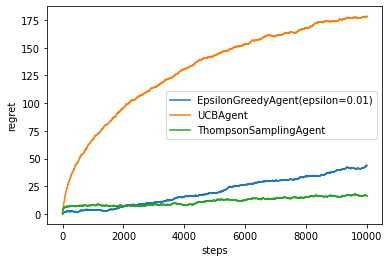

In [15]:
agents = [
    EpsilonGreedyAgent(),
    UCBAgent(),
    ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

# Nonstationary Bernoulli bandit

Что если вероятность успеха меняется со временем? Вот пример такого бандита:

In [17]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

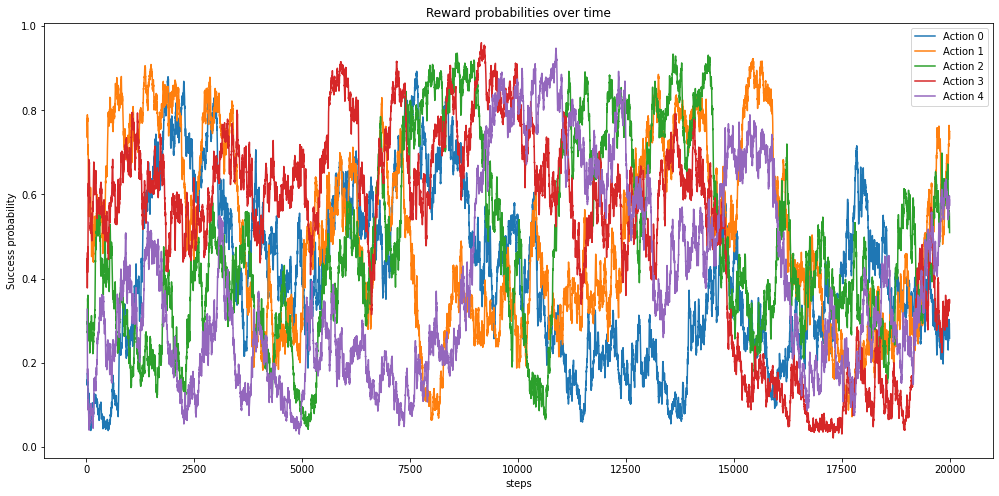

In [14]:


drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()



/tmp/ipykernel_16912/2808630493.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.argmax(self._successes / pulls + np.sqrt(2 * np.log(self._total_pulls + 0.1) / pulls))


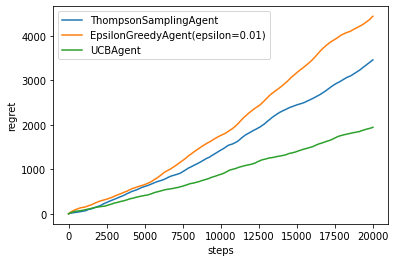

In [18]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
#     YourAgent()
]

regret = get_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)
plot_regret(drifting_agents, regret)